In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
walden_snapshot = 'subugoe-collaborative.openalex_walden.works'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
def calculate_changes(df1_openalex, df2_walden, on):
    changes = pd.merge(df1_openalex, df2_walden, on=on, how='outer', suffixes=('_openalex', '_walden'))

    changes['n_openalex'] = changes['n_openalex'].fillna(0)
    changes['n_walden'] = changes['n_walden'].fillna(0)
    changes = changes[[on, 'n_openalex', 'n_walden']]

    changes['change'] = changes['n_walden'] - changes['n_openalex']
    changes['pct_change'] = (changes['n_walden'] - changes['n_openalex']) / changes['n_openalex'] * 100
    changes['pct_change'] = changes['pct_change'].apply(lambda x: '{:,.2f}'.format(x))

    return changes

In [6]:
oal_by_types = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, type
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY type
                             ORDER BY n DESC
                             """).to_dataframe()

In [7]:
oal_by_types

,n,type
0,15610743,article
1,693450,review
2,427285,paratext
3,158396,letter
4,113624,editorial
5,72718,erratum
6,55909,dataset
7,47159,book-chapter
8,36094,reference-entry
9,21027,other


In [8]:
walden_by_types = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, type
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                                GROUP BY type
                                ORDER BY n DESC
                                """).to_dataframe()

In [9]:
walden_by_types

,n,type
0,15789640,article
1,688214,review
2,435787,paratext
3,156083,letter
4,112817,editorial
5,103777,book-chapter
6,72179,erratum
7,32940,reference-entry
8,24106,preprint
9,20564,other


In [10]:
calculate_changes(oal_by_types, walden_by_types, on='type')

,type,n_openalex,n_walden,change,pct_change
0,article,15610743,15789640,178897,1.15
1,review,693450,688214,-5236,-0.76
2,paratext,427285,435787,8502,1.99
3,letter,158396,156083,-2313,-1.46
4,editorial,113624,112817,-807,-0.71
5,erratum,72718,72179,-539,-0.74
6,dataset,55909,1410,-54499,-97.48
7,book-chapter,47159,103777,56618,120.06
8,reference-entry,36094,32940,-3154,-8.74
9,other,21027,20564,-463,-2.20


In [96]:
print(calculate_changes(oal_by_types, walden_by_types, on='type').to_markdown())

|    | type                    |   n_openalex |   n_walden |   change | pct_change   |
|---:|:------------------------|-------------:|-----------:|---------:|:-------------|
|  0 | article                 |     15610743 |   15789640 |   178897 | 1.15         |
|  1 | review                  |       693450 |     688214 |    -5236 | -0.76        |
|  2 | paratext                |       427285 |     435787 |     8502 | 1.99         |
|  3 | letter                  |       158396 |     156083 |    -2313 | -1.46        |
|  4 | editorial               |       113624 |     112817 |     -807 | -0.71        |
|  5 | erratum                 |        72718 |      72179 |     -539 | -0.74        |
|  6 | dataset                 |        55909 |       1410 |   -54499 | -97.48       |
|  7 | book-chapter            |        47159 |     103777 |    56618 | 120.06       |
|  8 | reference-entry         |        36094 |      32940 |    -3154 | -8.74        |
|  9 | other                   |        210

In [11]:
oal_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM `subugoe-collaborative.openalex.works`
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [12]:
oal_by_source_types

,n,source_type
0,17281019,journal
1,3677588,None
2,3593723,repository
3,2732665,ebook platform
4,664146,book series
5,568721,conference
6,11,other


In [13]:
walden_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM {walden_snapshot}
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [14]:
walden_by_source_types

,n,source_type
0,28683477,repository
1,17471480,journal
2,6219639,None
3,5336999,igsnCatalog
4,1768359,ebook platform
5,661015,book series
6,301813,conference
7,135,metadata
8,54,other
9,4,raidRegistry


In [15]:
calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type')

,source_type,n_openalex,n_walden,change,pct_change
0,journal,17281019,17471480,190461,1.10
1,None,3677588,6219639,2542051,69.12
2,repository,3593723,28683477,25089754,698.15
3,ebook platform,2732665,1768359,-964306,-35.29
4,book series,664146,661015,-3131,-0.47
5,conference,568721,301813,-266908,-46.93
6,other,11,54,43,390.91
7,igsnCatalog,0,5336999,5336999,inf
8,metadata,0,135,135,inf
9,raidRegistry,0,4,4,inf


In [95]:
print(calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type').to_markdown())

|    | source_type    |   n_openalex |   n_walden |   change |   pct_change |
|---:|:---------------|-------------:|-----------:|---------:|-------------:|
|  0 | journal        |     17281019 |   17471480 |   190461 |         1.1  |
|  1 |                |      3677588 |    6219639 |  2542051 |        69.12 |
|  2 | repository     |      3593723 |   28683477 | 25089754 |       698.15 |
|  3 | ebook platform |      2732665 |    1768359 |  -964306 |       -35.29 |
|  4 | book series    |       664146 |     661015 |    -3131 |        -0.47 |
|  5 | conference     |       568721 |     301813 |  -266908 |       -46.93 |
|  6 | other          |           11 |         54 |       43 |       390.91 |
|  7 | igsnCatalog    |            0 |    5336999 |  5336999 |       inf    |
|  8 | metadata       |            0 |        135 |      135 |       inf    |
|  9 | raidRegistry   |            0 |          4 |        4 |       inf    |


In [19]:
oal_by_oa = client.query(f"""
                          SELECT COUNT(DISTINCT(doi)) AS n, open_access.is_oa, open_access.oa_status
                          FROM {openalex_snapshot}
                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                          GROUP BY is_oa, oa_status
                          ORDER BY n DESC
                          """).to_dataframe()

In [20]:
oal_by_oa

,n,is_oa,oa_status
0,6639794,False,closed
1,4419565,True,gold
2,2097302,True,hybrid
3,1469074,True,bronze
4,1178478,True,diamond
5,499993,True,green


In [21]:
walden_by_oa = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, open_access.is_oa, open_access.oa_status
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY is_oa, oa_status
                             ORDER BY n DESC
                             """).to_dataframe()

In [22]:
walden_by_oa

,n,is_oa,oa_status
0,5646360,False,closed
1,4412769,True,diamond
2,2884933,True,gold
3,1848233,True,hybrid
4,1197094,True,bronze
5,488679,True,green
6,15,True,closed


In [23]:
calculate_changes(oal_by_oa, walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status')

,oa_status,n_openalex,n_walden,change,pct_change
0,closed,6639794,5646375,-993419,-14.96
1,gold,4419565,2884933,-1534632,-34.72
2,hybrid,2097302,1848233,-249069,-11.88
3,bronze,1469074,1197094,-271980,-18.51
4,diamond,1178478,4412769,3234291,274.45
5,green,499993,488679,-11314,-2.26


In [99]:
print(calculate_changes(oal_by_oa, walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status').to_markdown())

|    | oa_status   |   n_openalex |   n_walden |   change |   pct_change |
|---:|:------------|-------------:|-----------:|---------:|-------------:|
|  0 | closed      |      6639794 |    5646375 |  -993419 |       -14.96 |
|  1 | gold        |      4419565 |    2884933 | -1534632 |       -34.72 |
|  2 | hybrid      |      2097302 |    1848233 |  -249069 |       -11.88 |
|  3 | bronze      |      1469074 |    1197094 |  -271980 |       -18.51 |
|  4 | diamond     |      1178478 |    4412769 |  3234291 |       274.45 |
|  5 | green       |       499993 |     488679 |   -11314 |        -2.26 |


In [33]:
oal_by_host = client.query(f"""
                            SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                            FROM {openalex_snapshot}
                            WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                            GROUP BY host_organization_name
                            ORDER BY n DESC
                            """).to_dataframe()

In [34]:
oal_by_host

,n,host_organization_name
0,4406230,None
1,2488907,Elsevier BV
2,808028,Multidisciplinary Digital Publishing Institute
3,786127,Springer Science+Business Media
4,736327,Wiley
...,...,...
6322,0,Allied Business Academies
6323,0,Harvard Law Review Association
6324,0,University of Iowa College of Law
6325,0,InnoVision Communications


In [35]:
walden_by_host = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY host_organization_name
                             ORDER BY n DESC
                             """).to_dataframe()

In [36]:
walden_by_host

,n,host_organization_name
0,4583234,None
1,2486832,Elsevier BV
2,806939,Multidisciplinary Digital Publishing Institute
3,792822,Springer Science+Business Media
4,733618,Wiley
...,...,...
6399,0,Sweet & Maxwell
6400,0,Middle East Forum
6401,0,University of Chicago Law School
6402,0,"Bioresource Research Center (BRC), Islamabad"


In [37]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,None,4406230,4583234,177004,4.02
1,Elsevier BV,2488907,2486832,-2075,-0.08
2,Multidisciplinary Digital Publishing Institute,808028,806939,-1089,-0.13
3,Springer Science+Business Media,786127,792822,6695,0.85
4,Wiley,736327,733618,-2709,-0.37
5,Taylor & Francis,367153,367539,386,0.11
6,Frontiers Media,267408,267480,72,0.03
7,Oxford University Press,252446,252470,24,0.01
8,SAGE Publishing,228762,228465,-297,-0.13
9,Institute of Electrical and Electronics Engineers,219312,218626,-686,-0.31


In [94]:
print(calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

|    | host_organization_name                            |   n_openalex |   n_walden |   change |   pct_change |
|---:|:--------------------------------------------------|-------------:|-----------:|---------:|-------------:|
|  0 |                                                   |      4406230 |    4583234 |   177004 |         4.02 |
|  1 | Elsevier BV                                       |      2488907 |    2486832 |    -2075 |        -0.08 |
|  2 | Multidisciplinary Digital Publishing Institute    |       808028 |     806939 |    -1089 |        -0.13 |
|  3 | Springer Science+Business Media                   |       786127 |     792822 |     6695 |         0.85 |
|  4 | Wiley                                             |       736327 |     733618 |    -2709 |        -0.37 |
|  5 | Taylor & Francis                                  |       367153 |     367539 |      386 |         0.11 |
|  6 | Frontiers Media                                   |       267408 |     267480 |       72 

In [39]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['change'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,None,4406230,4583234,177004,4.02
3,Springer Science+Business Media,786127,792822,6695,0.85
29,Thieme Medical Publishers (Germany),54470,57152,2682,4.92
1074,Q1285359,593,2068,1475,248.74
18,Cambridge University Press,96301,97682,1381,1.43
30,BMJ,52822,53899,1077,2.04
10,Lippincott Williams & Wilkins,214001,215062,1061,0.50
267,Peoples' Friendship University of Russia,2718,3778,1060,39.00
56,Science Press,16456,17285,829,5.04
14,Springer Nature,137535,138307,772,0.56


In [40]:
calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['change'], ascending=False).tail(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
92,JMIR Publications,9308,8672,-636,-6.83
69,African Journals OnLine,13173,12512,-661,-5.02
149,Akadémiai Kiadó,4960,4292,-668,-13.47
983,American Astronomical Society,673,1,-672,-99.85
9,Institute of Electrical and Electronics Engineers,219312,218626,-686,-0.31
232,InScience LLC,3228,2531,-697,-21.59
17,IOP Publishing,107898,107132,-766,-0.71
710,AI Publications,994,197,-797,-80.18
702,IJEAST,1003,191,-812,-80.96
63,Karger Publishers,14685,13693,-992,-6.76


In [41]:
oal_by_host_references = client.query(f"""
                                      SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                      FROM {openalex_snapshot}
                                      WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                      GROUP BY host_organization_name
                                      ORDER BY n DESC
                                      """).to_dataframe()

In [42]:
oal_by_host_references

,n,host_organization_name
0,99552763,Elsevier BV
1,42306176,Multidisciplinary Digital Publishing Institute
2,33877276,None
3,31926819,Springer Science+Business Media
4,31252965,Wiley
...,...,...
6322,0,Autonomous University of Tlaxcala
6323,0,Verlagsgruppe Beltz
6324,0,Boston University
6325,0,State University of New York


In [43]:
walden_by_host_references = client.query(f"""
                                          SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                          FROM {walden_snapshot}
                                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                          GROUP BY host_organization_name
                                          ORDER BY n DESC
                                          """).to_dataframe()

In [44]:
walden_by_host_references

,n,host_organization_name
0,109168132,Elsevier BV
1,45172150,Multidisciplinary Digital Publishing Institute
2,38620785,None
3,33222209,Springer Science+Business Media
4,32518662,Wiley
...,...,...
6399,0,World Association for Medicine and Law
6400,0,The Islamic College
6401,0,Sophia University
6402,0,Japanese Society of Toxicology


In [93]:
print(calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

|    | host_organization_name                            |   n_openalex |   n_walden |   change |   pct_change |
|---:|:--------------------------------------------------|-------------:|-----------:|---------:|-------------:|
|  0 | Elsevier BV                                       |     99552763 |  109168132 |  9615369 |         9.66 |
|  1 | Multidisciplinary Digital Publishing Institute    |     42306176 |   45172150 |  2865974 |         6.77 |
|  2 |                                                   |     33877276 |   38620785 |  4743509 |        14    |
|  3 | Springer Science+Business Media                   |     31926819 |   33222209 |  1295390 |         4.06 |
|  4 | Wiley                                             |     31252965 |   32518662 |  1265697 |         4.05 |
|  5 | Frontiers Media                                   |     15792532 |   16325262 |   532730 |         3.37 |
|  6 | Taylor & Francis                                  |     13892854 |   14534769 |   641915 

In [46]:
calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['change'], ascending=False).head(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
0,Elsevier BV,99552763,109168132,9615369,9.66
2,None,33877276,38620785,4743509,14.00
1,Multidisciplinary Digital Publishing Institute,42306176,45172150,2865974,6.77
12,Institute of Electrical and Electronics Engineers,6484987,8254147,1769160,27.28
3,Springer Science+Business Media,31926819,33222209,1295390,4.06
4,Wiley,31252965,32518662,1265697,4.05
11,Oxford University Press,6495768,7191019,695251,10.70
6,Taylor & Francis,13892854,14534769,641915,4.62
5,Frontiers Media,15792532,16325262,532730,3.37
16,IOP Publishing,3583768,4107191,523423,14.61


In [103]:
calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['change'], ascending=False).tail(20)

,host_organization_name,n_openalex,n_walden,change,pct_change
2317,Allergy and Immunology Society of Thailand,2434,0,-2434,-100.00
2267,Zoological Survey of India,2500,0,-2500,-100.00
2241,Pesticide Science Society of Japan,2539,0,-2539,-100.00
2240,United States Government Publishing Office,2541,0,-2541,-100.00
994,Başkent University,7639,5026,-2613,-34.21
2142,Society of Physicians and Naturalists,2753,0,-2753,-100.00
1954,Korean Academy of Nursing Administration,3226,0,-3226,-100.00
1408,AI Publications,5033,1440,-3593,-71.39
147,MAIK Nauka/Interperiodica,76426,72025,-4401,-5.76
1334,Sociedad Argentina de Cardiología,5307,863,-4444,-83.74


In [54]:
oal_by_pubyear = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                               FROM `subugoe-collaborative.openalex.works`
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2020 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY publication_year
                               ORDER BY publication_year DESC
                               """).to_dataframe()

In [55]:
oal_by_pubyear

,n,publication_year
0,5747463,2024
1,5385802,2023
2,5170934,2022
3,5168607,2021
4,4865503,2020


In [56]:
walden_by_pubyear = client.query(f"""
                                  SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                                  FROM {walden_snapshot}
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2020 AND 2024 AND (type = 'article' OR type = 'review')
                                  GROUP BY publication_year
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [57]:
walden_by_pubyear

,n,publication_year
0,5858802,2024
1,5417422,2023
2,5201685,2022
3,5111484,2021
4,4818824,2020


In [58]:
calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False)

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,5747463,5858802,111339,1.94
1,2023,5385802,5417422,31620,0.59
2,2022,5170934,5201685,30751,0.59
4,2020,4865503,4818824,-46679,-0.96
3,2021,5168607,5111484,-57123,-1.11


In [92]:
print(calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False).to_markdown())

|    |   publication_year |   n_openalex |   n_walden |   change |   pct_change |
|---:|-------------------:|-------------:|-----------:|---------:|-------------:|
|  0 |               2024 |      5747463 |    5858802 |   111339 |         1.94 |
|  1 |               2023 |      5385802 |    5417422 |    31620 |         0.59 |
|  2 |               2022 |      5170934 |    5201685 |    30751 |         0.59 |
|  4 |               2020 |      4865503 |    4818824 |   -46679 |        -0.96 |
|  3 |               2021 |      5168607 |    5111484 |   -57123 |        -1.11 |


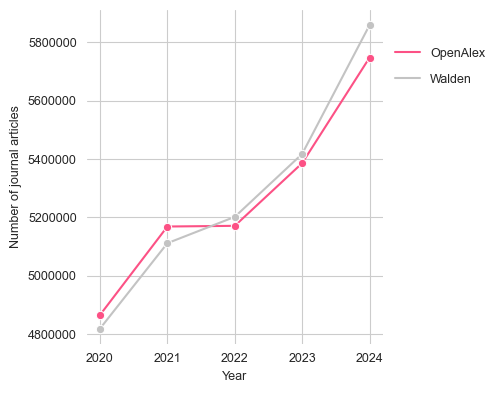

In [60]:
fig, ax = plt.subplots(figsize=(4,4))
plt.box(False)

sns.lineplot(data=oal_by_pubyear,
             x='publication_year',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=walden_by_pubyear,
             x='publication_year',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Year', ylabel='Number of journal articles')
ax.set_xticks(range(2020,2025))

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex')
walden_patch = Line2D([0], [0], color='#c3c3c3', label='Walden')

lgd = fig.legend(handles=[oal_patch, walden_patch], frameon=False,
                 bbox_to_anchor=(1.25, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oal_walden_comparison_article_pubyear.png', format='png', bbox_inches='tight', dpi=500)

In [61]:
oal_by_index = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY indexed_in
                             ORDER BY n DESC
                             """).to_dataframe()

In [62]:
oal_by_index

,n,indexed_in
0,11726898,[crossref]
1,3678404,"[crossref, pubmed]"
2,434098,"[crossref, doaj, pubmed]"
3,354468,"[crossref, doaj]"
4,45187,"[arxiv, crossref]"
5,40214,"[arxiv, crossref, datacite]"
6,8175,"[arxiv, crossref, pubmed]"
7,7136,"[arxiv, crossref, datacite, pubmed]"
8,4324,"[arxiv, crossref, datacite, doaj]"
9,1829,"[arxiv, crossref, doaj]"


In [63]:
oal_by_index_explode = oal_by_index.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [64]:
oal_by_index_explode

,indexed_in,n
1,crossref,16303367
4,pubmed,4129715
3,doaj,796361
0,arxiv,108489
2,datacite,53760


In [65]:
walden_by_index = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                GROUP BY indexed_in
                                ORDER BY n DESC
                                """).to_dataframe()

In [66]:
walden_by_index

,n,indexed_in
0,9793045,[crossref]
1,2520470,"[crossref, doaj]"
2,2288597,"[crossref, pubmed]"
3,1676637,"[crossref, doaj, pubmed]"
4,49587,[datacite]
5,33598,"[arxiv, crossref]"
6,27225,"[crossref, datacite]"
7,22918,"[crossref, datacite, pubmed]"
8,18804,"[crossref, datacite, doaj, pubmed]"
9,17290,"[arxiv, crossref, doaj]"


In [67]:
walden_by_index_explode = walden_by_index.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [68]:
walden_by_index_explode

,indexed_in,n
1,crossref,16424638
3,doaj,4250796
4,pubmed,4016339
2,datacite,138507
0,arxiv,66263


In [69]:
calculate_changes(oal_by_index_explode, walden_by_index_explode, on='indexed_in').sort_values(by=['change'], ascending=False)

,indexed_in,n_openalex,n_walden,change,pct_change
2,doaj,796361,4250796,3454435,433.78
0,crossref,16303367,16424638,121271,0.74
4,datacite,53760,138507,84747,157.64
3,arxiv,108489,66263,-42226,-38.92
1,pubmed,4129715,4016339,-113376,-2.75


In [91]:
print(calculate_changes(oal_by_index_explode, walden_by_index_explode, on='indexed_in').sort_values(by=['change'], ascending=False).to_markdown())

|    | indexed_in   |   n_openalex |   n_walden |   change |   pct_change |
|---:|:-------------|-------------:|-----------:|---------:|-------------:|
|  2 | doaj         |       796361 |    4250796 |  3454435 |       433.78 |
|  0 | crossref     |     16303367 |   16424638 |   121271 |         0.74 |
|  4 | datacite     |        53760 |     138507 |    84747 |       157.64 |
|  3 | arxiv        |       108489 |      66263 |   -42226 |       -38.92 |
|  1 | pubmed       |      4129715 |    4016339 |  -113376 |        -2.75 |


In [71]:
oal_by_index_all = client.query(f"""
                                 SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                 FROM `subugoe-collaborative.openalex.works`
                                 WHERE publication_year BETWEEN 2022 AND 2024
                                 GROUP BY indexed_in
                                 ORDER BY n DESC
                                 """).to_dataframe()

In [72]:
oal_by_index_all

,n,indexed_in
0,21173046,[crossref]
1,4043482,"[crossref, pubmed]"
2,1194723,[datacite]
3,557047,[]
4,451148,"[crossref, doaj, pubmed]"
5,359105,"[crossref, doaj]"
6,323673,"[arxiv, datacite]"
7,213369,[arxiv]
8,56908,[pubmed]
9,51195,"[arxiv, crossref]"


In [73]:
oal_by_index_all_explode = oal_by_index_all.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [74]:
oal_by_index_all_explode

,indexed_in,n
1,crossref,26149607
4,pubmed,4572091
2,datacite,1580251
3,doaj,840008
0,arxiv,659630


In [75]:
walden_by_index_all = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, indexed_in
                                FROM {walden_snapshot}
                                WHERE publication_year BETWEEN 2022 AND 2024
                                GROUP BY indexed_in
                                ORDER BY n DESC
                                """).to_dataframe()

In [76]:
walden_by_index_all

,n,indexed_in
0,31156824,[datacite]
1,19139923,[crossref]
2,2636076,"[crossref, doaj]"
3,2568401,"[crossref, pubmed]"
4,2187511,[]
5,1765027,"[crossref, doaj, pubmed]"
6,568439,"[arxiv, datacite]"
7,129313,[doaj]
8,54964,[pubmed]
9,47855,"[arxiv, crossref]"


In [77]:
walden_by_index_all_explode = walden_by_index_all.explode('indexed_in').groupby(['indexed_in'])['n'].sum().reset_index().sort_values(by=['n'], ascending=False)

In [78]:
walden_by_index_all_explode

,indexed_in,n
2,datacite,31878995
1,crossref,26296666
3,doaj,4629846
4,pubmed,4451665
0,arxiv,664824


In [79]:
calculate_changes(oal_by_index_all_explode, walden_by_index_all_explode, on='indexed_in').sort_values(by=['change'], ascending=False)

,indexed_in,n_openalex,n_walden,change,pct_change
2,datacite,1580251,31878995,30298744,"1,917.34"
3,doaj,840008,4629846,3789838,451.17
0,crossref,26149607,26296666,147059,0.56
4,arxiv,659630,664824,5194,0.79
1,pubmed,4572091,4451665,-120426,-2.63


In [100]:
print(calculate_changes(oal_by_index_all_explode, walden_by_index_all_explode, on='indexed_in').sort_values(by=['change'], ascending=False).to_markdown())

|    | indexed_in   |   n_openalex |   n_walden |   change | pct_change   |
|---:|:-------------|-------------:|-----------:|---------:|:-------------|
|  2 | datacite     |      1580251 |   31878995 | 30298744 | 1,917.34     |
|  3 | doaj         |       840008 |    4629846 |  3789838 | 451.17       |
|  0 | crossref     |     26149607 |   26296666 |   147059 | 0.56         |
|  4 | arxiv        |       659630 |     664824 |     5194 | 0.79         |
|  1 | pubmed       |      4572091 |    4451665 |  -120426 | -2.63        |


In [103]:
oal_grants = client.query(f"""
                           SELECT COUNT(grant.award_id) AS n, grant.funder_display_name
                           FROM `subugoe-collaborative.openalex.works`, UNNEST(grants) AS grant
                           WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                           GROUP BY funder_display_name
                           ORDER BY n DESC
                           """).to_dataframe()

In [104]:
oal_grants

,n,funder_display_name
0,1463516,National Natural Science Foundation of China
1,163991,National Key Research and Development Program ...
2,128342,Japan Society for the Promotion of Science
3,126402,National Institutes of Health
4,118946,National Science Foundation
...,...,...
27642,0,Bardham Research and Education Trust
27643,0,Beatrice and Reymont Paul Foundation
27644,0,Eosinophilic Family Coalition
27645,0,Australian Speleological Federation


In [105]:
oal_grants.n.sum()

5420652

In [106]:
walden_grants = client.query(f"""
                               SELECT COUNT(grant.id) AS n, grant.funder_display_name
                               FROM {walden_snapshot}, UNNEST(awards) AS grant
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY funder_display_name
                               ORDER BY n DESC
                               """).to_dataframe()

In [107]:
walden_grants

,n,funder_display_name
0,1456078,National Natural Science Foundation of China
1,162800,National Key Research and Development Program ...
2,126240,Japan Society for the Promotion of Science
3,121667,National Institutes of Health
4,115302,National Science Foundation
...,...,...
21521,1,Canadian Pain Society
21522,1,Institut des sciences humaines et sociales
21523,1,American Occupational Therapy Association
21524,1,"Institute of Pharmacy, Nirma University"


In [108]:
walden_grants.n.sum()

5506984

In [109]:
calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['n_openalex'], ascending=False).head(20)

,funder_display_name,n_openalex,n_walden,change,pct_change
0,National Natural Science Foundation of China,1463516,1456078,-7438,-0.51
1,National Key Research and Development Program ...,163991,162800,-1191,-0.73
2,Japan Society for the Promotion of Science,128342,126240,-2102,-1.64
3,National Institutes of Health,126402,121667,-4735,-3.75
4,National Science Foundation,118946,115302,-3644,-3.06
5,Fundamental Research Funds for the Central Uni...,87326,86439,-887,-1.02
6,Deutsche Forschungsgemeinschaft,86309,83882,-2427,-2.81
7,National Research Foundation of Korea,75647,75023,-624,-0.82
8,China Postdoctoral Science Foundation,60066,59785,-281,-0.47
9,Conselho Nacional de Desenvolvimento Científic...,43147,42657,-490,-1.14


In [110]:
calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['change'], ascending=False).head(20)

,funder_display_name,n_openalex,n_walden,change,pct_change
73,Medical Research Council,9486,43935,34449,363.16
97,Science and Technology Facilities Council,7645,41924,34279,448.38
13,Engineering and Physical Sciences Research Cou...,33358,66215,32857,98.50
6780,Sight Research UK,20,18953,18933,"94,665.00"
108,Natural Environment Research Council,6681,21357,14676,219.67
84,Biotechnology and Biological Sciences Research...,8669,23202,14533,167.64
147,Economic and Social Research Council,4398,11330,6932,157.62
420,Arts and Humanities Research Council,1023,2638,1615,157.87
1707,Shota Rustaveli National Science Foundation,177,187,10,5.65
5334,Universidad Técnica Particular de Loja,31,34,3,9.68


In [111]:
calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['change'], ascending=False).tail(20)

,funder_display_name,n_openalex,n_walden,change,pct_change
14,Australian Research Council,28688,28250,-438,-1.53
43,Horizon 2020 Framework Programme,15494,15045,-449,-2.90
9,Conselho Nacional de Desenvolvimento Científic...,43147,42657,-490,-1.14
538,Argonne National Laboratory,749,242,-507,-67.69
93,Basic Energy Sciences,7922,7387,-535,-6.75
42,National Aeronautics and Space Administration,15776,15228,-548,-3.47
50,European Research Council,13427,12876,-551,-4.10
34,H2020 European Research Council,19039,18456,-583,-3.06
7,National Research Foundation of Korea,75647,75023,-624,-0.82
5,Fundamental Research Funds for the Central Uni...,87326,86439,-887,-1.02


In [112]:
print(calculate_changes(oal_grants, walden_grants, on='funder_display_name').sort_values(by=['n_openalex'], ascending=False).head(20).to_markdown())

|    | funder_display_name                                               |   n_openalex |   n_walden |   change |   pct_change |
|---:|:------------------------------------------------------------------|-------------:|-----------:|---------:|-------------:|
|  0 | National Natural Science Foundation of China                      |      1463516 |    1456078 |    -7438 |        -0.51 |
|  1 | National Key Research and Development Program of China            |       163991 |     162800 |    -1191 |        -0.73 |
|  2 | Japan Society for the Promotion of Science                        |       128342 |     126240 |    -2102 |        -1.64 |
|  3 | National Institutes of Health                                     |       126402 |     121667 |    -4735 |        -3.75 |
|  4 | National Science Foundation                                       |       118946 |     115302 |    -3644 |        -3.06 |
|  5 | Fundamental Research Funds for the Central Universities           |        87326 |      86